# Prédiction de la note des vins

Le notebook compare plusieurs de modèles de régression.

In [13]:
%matplotlib inline

In [14]:
import warnings

warnings.simplefilter("ignore")

In [15]:
from teachpyx.datasets import load_wines_dataset

df = load_wines_dataset()
X = df.drop(["quality", "color"], axis=1)
y = yn = df["quality"]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

On normalise les données.

In [17]:
from sklearn.preprocessing import normalize

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)
X_norm = normalize(X)

Cette façon de faire est complètement erronnée car il est peu probable que la même normalisation soit apppliquée sur les trois bases. La normalisation doit être estimée sur la base d'apprentissage et appliquée sur la base de test. Reprenons.

In [18]:
from sklearn.preprocessing import Normalizer

norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)
X_norm = norm.transform(X)

On récupère beaucoup de modèles implémentés dans *scikit-learn* pour la régression.

In [19]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.neural_network import *

models = [
    model
    for name, model in globals().items()
    if (
        hasattr(model, "fit")
        and not hasattr(model, "predict_proba")
        and hasattr(model, "__name__")
        and not model.__name__.endswith("CV")
        and "Logistic" not in model.__name__
        and "Regr" in model.__name__
    )
]

import pprint

pprint.pprint(models)

[<class 'sklearn.linear_model._bayes.ARDRegression'>,
 <class 'sklearn.linear_model._huber.HuberRegressor'>,
 <class 'sklearn.linear_model._base.LinearRegression'>,
 <class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor'>,
 <class 'sklearn.linear_model._quantile.QuantileRegressor'>,
 <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>,
 <class 'sklearn.linear_model._theil_sen.TheilSenRegressor'>,
 <class 'sklearn.linear_model._ransac.RANSACRegressor'>,
 <class 'sklearn.linear_model._glm.glm.PoissonRegressor'>,
 <class 'sklearn.linear_model._glm.glm.GammaRegressor'>,
 <class 'sklearn.linear_model._glm.glm.TweedieRegressor'>,
 <class 'sklearn.ensemble._forest.RandomForestRegressor'>,
 <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>,
 <class 'sklearn.ensemble._bagging.BaggingRegressor'>,
 <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>,
 <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>,
 <class 'sklearn.ensemble._voting.Votin

In [20]:
from sklearn.metrics import r2_score


def score_model(xtr, xte, ytr, yte, model):
    try:
        model.fit(xtr, ytr)
    except Exception as e:
        raise Exception("Issue with model '{0}'".format(model.__name__)) from e
    return r2_score(yte, model.predict(xte))

In [21]:
from time import perf_counter

r2s = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {
        "ARDRegression",
        "VotingRegressor",
        "StackingRegressor",
        "QuantileRegressor",
    }:
        continue
    try:
        reg = model()
    except Exception as e:
        print("Skip", model)
        continue
    begin = perf_counter()
    r2 = score_model(X_train_norm, X_test_norm, y_train, y_test, reg)
    duree = perf_counter() - begin
    r2s.append(r2)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, duree)

1 HuberRegressor 0.15264869419166682 1.0747132999999849
2 LinearRegression 0.17989904732301487 0.029094200000145065
3 PassiveAggressiveRegressor -0.06283962040801283 0.022322499999972933
5 SGDRegressor 0.008293681864454783 0.019755700000132492
6 TheilSenRegressor -0.29442406131949195 1.6061727999999675
7 RANSACRegressor 0.09980597599411645 0.2597002999996221
8 PoissonRegressor 0.0013198388054543875 0.09024569999974119
9 GammaRegressor -0.00011329963875650328 0.02906749999965541
10 TweedieRegressor -0.00012663753861930083 0.06156760000021677
11 RandomForestRegressor 0.4779574483287953 13.056004900000062
12 ExtraTreesRegressor 0.4994834890638471 1.7028706000000966
13 BaggingRegressor 0.41813406357742 1.2051542999997764
14 GradientBoostingRegressor 0.3223761613299607 4.173846099999992
15 AdaBoostRegressor 0.20700608833439227 0.6709999999998217
18 HistGradientBoostingRegressor 0.4239913847044323 0.7730876000000535
19 KNeighborsRegressor 0.18152755024686895 0.06760649999978341
20 RadiusNeig

In [22]:
import pandas

df = pandas.DataFrame(dict(model=names, r2=r2s, duree=durations))
df = df[["model", "r2", "duree"]]
df.sort_values("r2")

,model,r2,duree
4,TheilSenRegressor,-0.294424,1.606173
2,PassiveAggressiveRegressor,-0.062840,0.022322
16,RadiusNeighborsRegressor,-0.000409,0.708230
8,TweedieRegressor,-0.000127,0.061568
7,GammaRegressor,-0.000113,0.029067
6,PoissonRegressor,0.001320,0.090246
3,SGDRegressor,0.008294,0.019756
5,RANSACRegressor,0.099806,0.259700
0,HuberRegressor,0.152649,1.074713
1,LinearRegression,0.179899,0.029094


On filtre les valeurs inférieures à -1.

In [23]:
df = df[df.r2 >= -1]

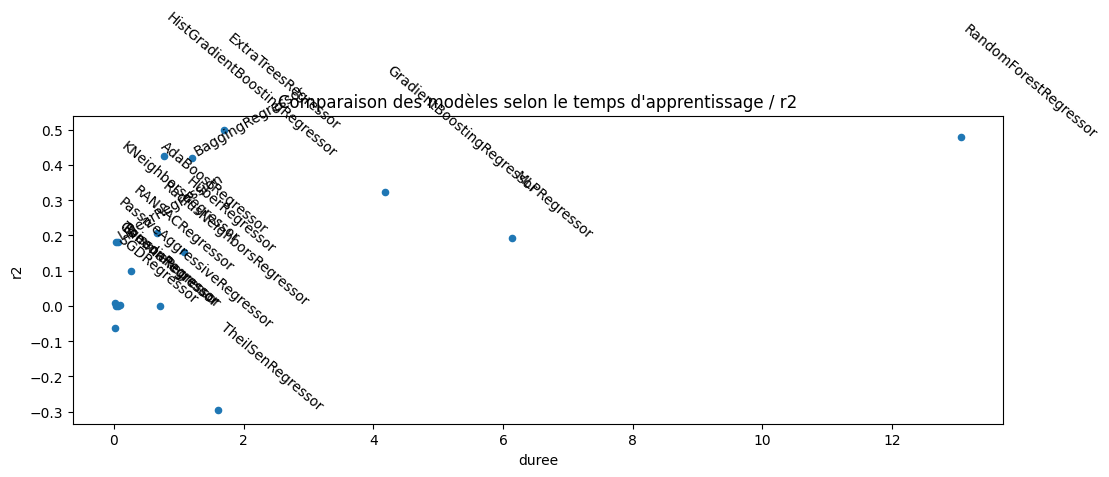

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
df.plot(x="duree", y="r2", kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, x = row[1:4]
    if t[0] in {"B", "L"}:
        ax.text(x, y, t, rotation=30, ha="left", va="bottom")
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_title("Comparaison des modèles selon le temps d'apprentissage / r2");

L'estimateur [RANSACRegressor](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py) produit un $R^2$ très négatif. Regardons plus en détail.

In [25]:
pred = regressors["RANSACRegressor"].predict(X_test_norm)

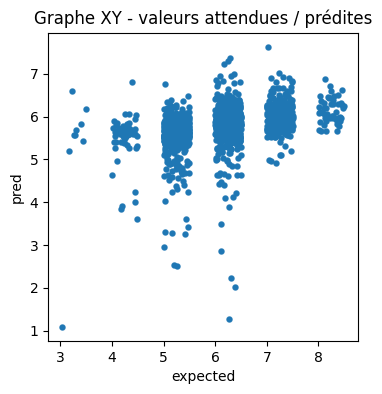

In [26]:
import numpy.random

df = pandas.DataFrame(dict(pred=pred, expected=y_test))
df["expected"] += numpy.random.random(df.shape[0]) * 0.5
ax = df.plot(x="expected", y="pred", kind="scatter", figsize=(4, 4), linewidths=0.1)
ax.set_title("Graphe XY - valeurs attendues / prédites");

Essayons de voir avec la densité.

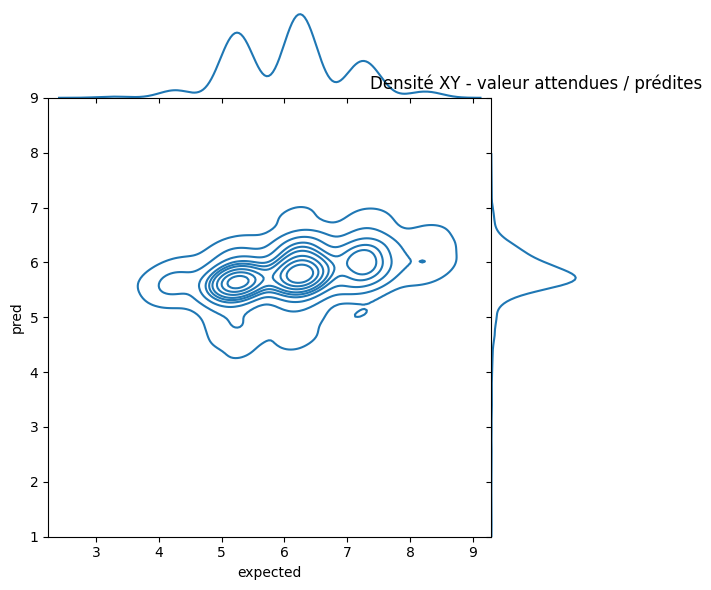

In [30]:
import seaborn

ax = seaborn.jointplot(
    df, x="expected", y="pred", kind="kde", size=4, space=0, ylim=(1, 9)
)
ax.ax_marg_y.set_title("Densité XY - valeur attendues / prédites");

Pas facile à voir. Essayons de voir autrement en triant les prédictions et les valeurs attendues par ordre.

In [31]:
sv = df.sort_values(["expected", "pred"]).reset_index(drop=True)

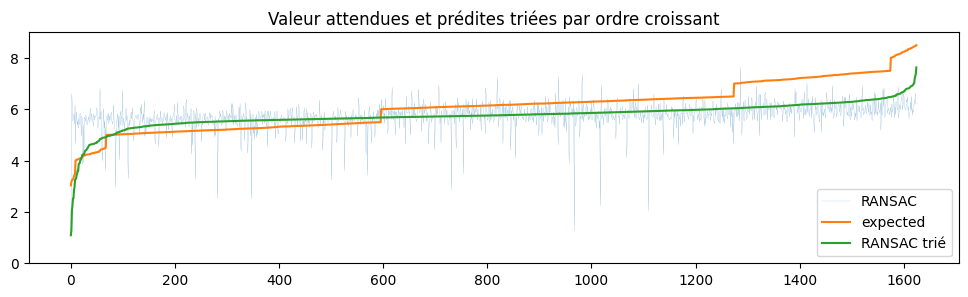

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(sv["pred"], label="RANSAC", lw=0.1)
ax.plot(list(sorted(df["expected"])), label="expected")
ax.plot(list(sorted(df["pred"])), label="RANSAC trié")
ax.set_ylim([0, 9])
ax.set_title("Valeur attendues et prédites triées par ordre croissant")
ax.legend();

Le modèle est plutôt agité.

In [33]:
regressors["RANSACRegressor"].estimator_.intercept_

-0.3658125914901369

Pour s'assurer que les résultats sont fiables, il faut recommencer avec une validation croisée.

In [34]:
import numpy.random

rnd = numpy.random.permutation(range(X_norm.shape[0]))
xns = X_norm[rnd, :]
yns = yn[rnd]
xns.shape, yns.shape

((6497, 11), (6497,))

In [35]:
from sklearn.model_selection import cross_val_score


def score_model_cross(xn, yn, model):
    res = cross_val_score(model, xn, yn, cv=3)
    return res.mean(), min(res), max(res)


score_model_cross(xns, yns, LinearRegression())

(0.1799448611096674, 0.16609433123462292, 0.20072693380863527)

In [41]:
from teachpyx.ext_test_case import unit_test_going

r2s = []
mis = []
mas = []
names = []
durations = []
regressors = {}
for i, model in enumerate(models):
    if model.__name__ in {
        "ARDRegression",
        "VotingRegressor",
        "QuantileRegressor",
        "MLPRegressor",
        "RandomForestRegressor",
        "GradientBoostingRegressor",  # too long
    }:
        continue
    if unit_test_going() and not model.__name__ not in {
        "LinearRegression",
        "SGDRegressor",
    }:
        continue
    try:
        reg = model()
    except Exception as e:
        print("Skip", model)
        continue
    begin = perf_counter()
    r2, mi, ma = score_model_cross(xns, yns, reg)
    duree = perf_counter() - begin
    r2s.append(r2)
    mis.append(mi)
    mas.append(ma)
    names.append(model.__name__)
    durations.append(duree)
    regressors[model.__name__] = reg
    print(i, model.__name__, r2, mi, ma, "t=%r" % duree)

1 HuberRegressor 0.16445120603440527 0.15765403941480316 0.1786143072062636 t=1.435193799999979
2 LinearRegression 0.1799448611096674 0.16609433123462292 0.20072693380863527 t=0.047846299999946496
3 PassiveAggressiveRegressor -0.8998543024559884 -2.5295972496836714 -0.08733290068040933 t=0.13489810000010038
5 SGDRegressor 0.00973904451751757 -0.004417086935930126 0.01816079178339436 t=0.11661329999969894
6 TheilSenRegressor -0.3139016667645712 -0.41907116748283557 -0.224530428533247 t=6.356290799999897
7 RANSACRegressor -5.4384892594797405 -12.400989908758083 -1.1372714492625668 t=1.0156056000000717
8 PoissonRegressor 0.0011212946218149167 -0.00022109795646318986 0.0020054507493099116 t=0.3450553999996373
9 GammaRegressor -0.0005558618017731165 -0.0021320248191363245 0.00030404381558213345 t=0.25818170000002283
10 TweedieRegressor -0.0005670558820739524 -0.002194268482211603 0.0003060535183355695 t=0.3232327999999143
12 ExtraTreesRegressor 0.5150920905590446 0.48820834539223157 0.53388

In [44]:
df = pandas.DataFrame(dict(model=names, r2=r2s, min=mis, max=mas, duree=durations))
df = df[["model", "r2", "min", "max", "duree"]]
df.sort_values("r2")

,model,r2,min,max,duree
5,RANSACRegressor,-5.438489,-12.400990,-1.137271,1.015606
2,PassiveAggressiveRegressor,-0.899854,-2.529597,-0.087333,0.134898
4,TheilSenRegressor,-0.313902,-0.419071,-0.224530,6.356291
14,RadiusNeighborsRegressor,-0.000859,-0.002576,0.000308,3.321715
8,TweedieRegressor,-0.000567,-0.002194,0.000306,0.323233
7,GammaRegressor,-0.000556,-0.002132,0.000304,0.258182
6,PoissonRegressor,0.001121,-0.000221,0.002005,0.345055
3,SGDRegressor,0.009739,-0.004417,0.018161,0.116613
0,HuberRegressor,0.164451,0.157654,0.178614,1.435194
13,KNeighborsRegressor,0.165329,0.087542,0.197882,0.167346


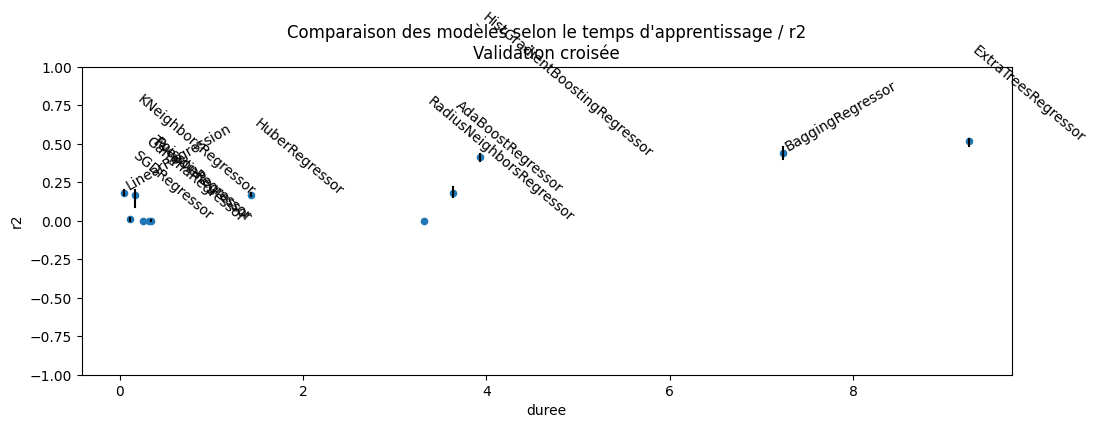

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
df[df["min"] > -0.1].plot(x="duree", y="r2", kind="scatter", ax=ax)
for row in df.itertuples():
    t, y, mi, ma, x = row[1:6]
    if mi < -0.1:
        continue
    ax.plot([x, x], [mi, ma], color="black")
    if t[0] in {"B", "L"}:
        ax.text(x, y, t, rotation=30, ha="left", va="bottom")
    else:
        ax.text(x, y, t, rotation=-40)
ax.set_ylim([-1, 1])
ax.set_title(
    "Comparaison des modèles selon le temps d'apprentissage / r2\nValidation croisée"
);

Le modèle [RANSAC](http://scikit-learn.org/stable/modules/linear_model.html#ransac-random-sample-consensus) est conçu pour apprendre un modèle linéaire et réduire l'ensemble d'apprentissage aux points non aberrants. Dans notre cas, vu le peu d'exemples pour les notes élevées, il est très probable que celles-ci disparaissent des observations choisies pour estimer le modèle : le modèle choisit d'évincer les exemples pour lesquels l'erreur est la plus grande en considérant que cela est une indication du fait qu'ils sont aberrants. Malgré cela, sa faible capacité à prévoir vient du fait que la majorité des vins ont une note entre 4 et 6 et que finalement, il y a peu de différences : ils sont tous moyens et la différence s'explique par d'autres facteurs comme le juge ayant donné la note.